# FQI on Bicycle

## Define parameters

In [39]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import jax
import jax.numpy as jnp
import os
import json

parameters = json.load(open("parameters.json"))
env_seed = parameters["env_seed"]
gamma = parameters["gamma"]
# Sample collection
n_samples = parameters["n_samples"]

# Trainings
layers_dimension = parameters["layers_dimension"]
max_bellman_iterations = parameters["max_bellman_iterations"]
batch_size_samples = n_samples
fitting_steps = parameters["fitting_steps_fqi"]
learning_rate = {"first": parameters["starting_lr_fqi"], "last": parameters["ending_lr_fqi"], "duration": fitting_steps * n_samples // batch_size_samples}
max_patience = parameters["patience"]

# Visualisation of errors and performances
n_omegas = parameters["n_omegas"]
n_thetas = parameters["n_thetas"]
horizon = parameters["horizon"]

# Search for an unused seed
max_used_seed = 0
if not os.path.exists("figures/data/FQI/"):
    os.makedirs("figures/data/FQI/")
for file in os.listdir("figures/data/FQI/"):
    if int(file.split("_")[0]) == max_bellman_iterations and int(file.split("_")[2][:-4]) > max_used_seed:
        max_used_seed = int(file.split("_")[2][:-4])
max_used_seed

# keys
seed = max_used_seed + 1
env_key = jax.random.PRNGKey(env_seed)
env_key, sample_key = jax.random.split(env_key)
key = jax.random.PRNGKey(seed)
shuffle_key, q_network_key, _ = jax.random.split(key, 3) # 3 keys are generated to be coherent with the other trainings

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define environment

In [40]:
import numpy as np

from pbo.environments.bicycle import BicycleEnv


env = BicycleEnv(env_key)

omegas = jnp.linspace(-env.omega_bound, env.omega_bound, n_omegas)
boxes_omega_size = (2 * env.omega_bound) / (n_omegas - 1)
omega_boxes = (np.linspace(-env.omega_bound, env.omega_bound + boxes_omega_size, n_omegas + 1) - boxes_omega_size / 2)
thetas = jnp.linspace(-env.theta_bound, env.theta_bound, n_thetas)
boxes_theta_size = (2 * env.theta_bound) / (n_thetas - 1)
theta_boxes = (np.linspace(-env.theta_bound, env.theta_bound + boxes_theta_size, n_thetas + 1) - boxes_theta_size / 2)

## Collect samples

### Samples on the mesh and with a uniform policy

In [41]:
from pbo.sample_collection.replay_buffer import ReplayBuffer


replay_buffer = ReplayBuffer()

env.reset()
n_episodes = 0
positions = [[env.position]]

for idx_sample in range(n_samples):
    state = env.state
    
    sample_key, key = jax.random.split(sample_key)
    action = jax.random.randint(key, shape=(2,), minval=-1, maxval=2)
    
    next_state, reward, absorbing, _ = env.step(action)
    positions[n_episodes].append(env.position)

    replay_buffer.add(state, action, reward, next_state, absorbing)

    if absorbing[0]:
        env.reset()
        positions[n_episodes] = np.array(positions[n_episodes])
        positions.append([])
        n_episodes += 1

replay_buffer.cast_to_jax_array()
assert sum(replay_buffer.rewards == -1) > 0, "No negative reward has been sampled, please do something!"
print(f"Number of episodes: {n_episodes}")

Number of episodes: 1090


### Visualize samples

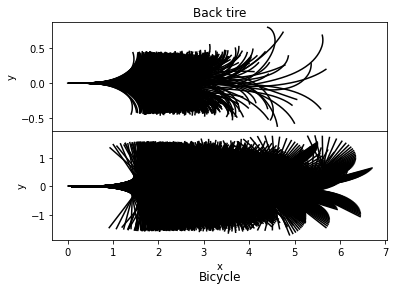

In [42]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

for episode in range(n_episodes):
    ax1.plot(positions[episode][:, 0], positions[episode][:, 1], color="black")

    for step in range(len(positions[episode])):
        ax2.plot(positions[episode][step, [0, 2]], positions[episode][step, [1, 3]], color="black")


ax1.get_xaxis().set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.set_ylabel("y")
ax1.set_title(f"Back tire")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title(f"Bicycle", y=0, pad=-30, verticalalignment="top")

plt.subplots_adjust(hspace=0)

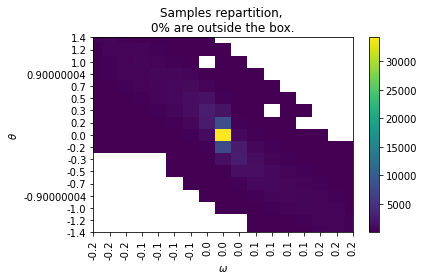

In [43]:
from pbo.sample_collection.count_samples import count_samples
from pbo.utils.two_dimesions_mesh import TwoDimesionsMesh


zero_oder_count, n_outside_boxes, rewards_count = count_samples(replay_buffer.states[:, 0], replay_buffer.states[:, 2], omega_boxes, theta_boxes, replay_buffer.rewards)
zero_oder_visu_mesh = TwoDimesionsMesh(omegas, thetas, sleeping_time=0, axis_equal=False)

zero_oder_visu_mesh.set_values(zero_oder_count, zeros_to_nan=True)
zero_oder_visu_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box.", xlabel=r"$\omega$", ylabel=r"$\theta$"
)

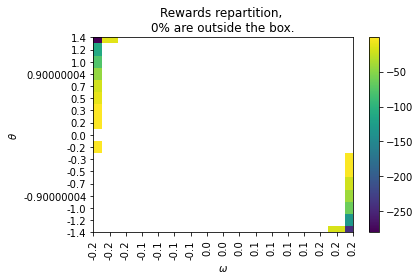

In [44]:
zero_oder_visu_mesh.set_values(rewards_count, zeros_to_nan=True)
zero_oder_visu_mesh.show(
    f"Rewards repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box.", xlabel=r"$\omega$", ylabel=r"$\theta$"
)

In [45]:
max_omega_dot = replay_buffer.states[:, 1].max()
min_omega_dot = replay_buffer.states[:, 1].min()

omega_dots = jnp.linspace(min_omega_dot, max_omega_dot, n_omegas)

max_theta_dot = replay_buffer.states[:, 3].max()
min_theta_dot = replay_buffer.states[:, 3].min()

theta_dots = jnp.linspace(min_theta_dot, max_theta_dot, n_thetas)

## Train FQI

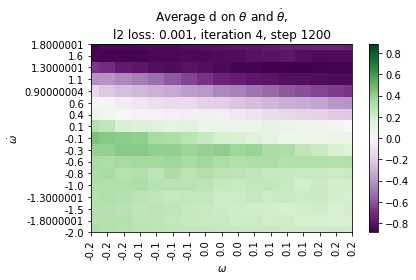

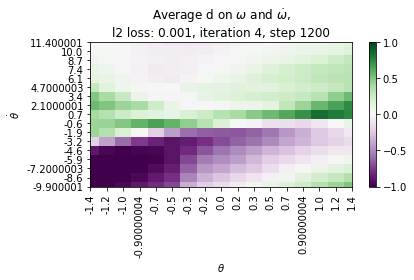

In [46]:
import matplotlib.pyplot as plt

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.networks.learnable_q import FullyConnectedQ


data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
q = FullyConnectedQ(
    state_dim=5,
    action_dim=2,
    actions_on_max=env.actions_on_max,
    gamma=gamma,
    network_key=q_network_key,
    layers_dimension=layers_dimension,
    zero_initializer=True,
    learning_rate=learning_rate
)

omega_visu_mesh = TwoDimesionsMesh(omegas, omega_dots, sleeping_time=0, axis_equal=False, zero_centered=True)
theta_visu_mesh = TwoDimesionsMesh(thetas, theta_dots, sleeping_time=0, axis_equal=False, zero_centered=True)
l2_losses = np.ones((max_bellman_iterations, fitting_steps)) * np.nan

for bellman_iteration in range(1, max_bellman_iterations + 1):
    q.reset_optimizer()
    params_target = q.params
    best_loss = float('inf')
    patience = 0

    for step in range(fitting_steps):
        cumulative_l2_loss = 0
        
        data_loader_samples.shuffle()
        for batch_samples in data_loader_samples:
            q.params, q.optimizer_state, l2_loss = q.learn_on_batch(q.params, params_target, q.optimizer_state, batch_samples)
            cumulative_l2_loss += l2_loss

        l2_losses[bellman_iteration - 1, step] = cumulative_l2_loss
        if cumulative_l2_loss < best_loss:
            patience = 0
            best_loss = cumulative_l2_loss
        else:
            patience += 1

        if patience > max_patience:
            break

    d_on_omegas, T_on_thetas = env.best_action_on_mesh(q, q.params, omegas, omega_dots, thetas, theta_dots)

    omega_visu_mesh.set_values(d_on_omegas)
    omega_visu_mesh.show(r"Average d on $\theta$ and $\dot{\theta}$," + f"\nl2 loss: {str(jnp.round(cumulative_l2_loss, 3))}, iteration {bellman_iteration}, step {step + 1}", xlabel=r"$\omega$", ylabel=r"$\dot{\omega}$")
    theta_visu_mesh.set_values(T_on_thetas)
    theta_visu_mesh.show(r"Average d on $\omega$ and $\dot{\omega}$," + f"\nl2 loss: {str(jnp.round(cumulative_l2_loss, 3))}, iteration {bellman_iteration}, step {step + 1}", xlabel=r"$\theta$", ylabel=r"$\dot{\theta}$", clear=False)

for bellman_iteration in range(0, max_bellman_iterations, max(max_bellman_iterations // 10, 1)):
    plt.plot(l2_losses[bellman_iteration], label=f"Iteration {bellman_iteration + 1}")

plt.legend()
plt.xlabel("fitting step")
plt.ylabel(r"$(\Gamma^*Q_i - Q_{i +  1})^2$")
plt.title("Training losses")
plt.show()

In [ ]:
# bellman_iteration = -1

# q_visu_mesh.set_values((iterated_q[bellman_iteration, :, :, 1] > iterated_q[bellman_iteration, :, :, 0]).astype(float))
# q_visu_mesh.show(f"FQI Q policy, {max_bellman_iterations} iterations", xlabel="x", ylabel="v")

In [ ]:
env.simulate(q, horizon, render=True)

60

In [ ]:
# final_v = env.v_mesh(q, horizon, states_x, states_v)

# average_performance = final_v * samples_count

# q_visu_mesh.set_values(average_performance)
# q_visu_mesh.show(r"$V^{\pi_{fqi}}, \mathbb{E}\left[ V^{\pi_{fqi}} \right] =$" + str(np.round(np.mean(average_performance), 2)), xlabel="x", ylabel="v")

## Save the data

In [ ]:
# np.save(f"figures/data/FQI/{max_bellman_iterations}_Q_{seed}.npy", iterated_q)
# np.save(f"figures/data/FQI/{max_bellman_iterations}_V_{seed}.npy", iterated_v)